# MODFLOW 6 : ejemplo simple en 1D.

# Resumen.

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/mf6_tutorial/">MODFLOW 6: tutorial</a> by <b>Luis M. de la Cruz Salas (2025)</b> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>.</p> 

<div class="alert alert-block alert-success">

## Ejemplo.

Resolver el flujo en un dominio unidimensional, estacionario, con condiciones de frontera tipo Dirichlet y parámetros de flujo constantes.

</div>

ncol =  5


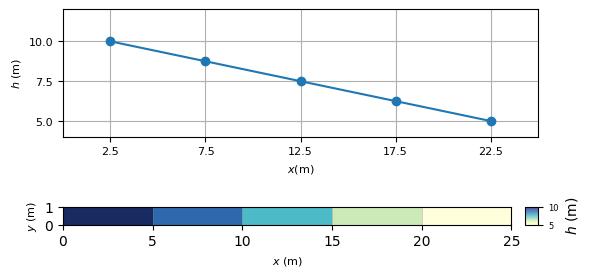

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import flopy # Pre y post procesamiento
import xmf6 # Funcionalidades auxiliares

# --- Componentes ---

# Parámetros de la simulación (flopy.mf6.MFSimulation)
init = {
    'sim_name' : "flow",
    'exe_name' : "C:\\Users\\luiggi\\Documents\\GitSites\\mf6_tutorial\\mf6\\windows\\mf6",
#    'exe_name' : "../../mf6/macosarm/mf6",
    'sim_ws' : "sandbox0"
}

# Parámetros para el tiempo (flopy.mf6.ModflowTdis)
tdis = {
    'units': "DAYS",
    'nper' : 1,
    'perioddata': [(1.0, 1, 1.0)]
}

# Parámetros para la solución numérica (flopy.mf6.ModflowIms)
ims = {}

# Parámetros para el modelo de flujo (flopy.mf6.ModflowGwf)
gwf = { 
    'modelname': init["sim_name"],
    'model_nam_file': f"{init["sim_name"]}.nam",
    'save_flows': True
}

# --- Paquetes del modelo de flujo ---
lx = 25
ncol = int(input("ncol = "))
delr = lx / ncol 
# Parámetros para la discretización espacial (flopy.mf6.ModflowGwfdis)
dis = {
    'length_units': "meters",
    'nlay': 1, 
    'nrow': 1, 
    'ncol': ncol,
    'delr': delr, 
    'delc': 1.0, 
    'top' : 1.0, 
    'botm': 0.0 
}

# Parámetros para las condiciones iniciales (flopy.mf6.ModflowGwfic)
ic = {
    'strt': 1.0
}

# Parámetros para las condiciones de frontera (flopy.mf6.ModflowGwfchd)
chd_data = []
for row in range(dis['nrow']):
    chd_data.append([(0, row, 0), 10.0])       # Condición en la pared izquierda
    chd_data.append([(0, row, dis['ncol'] - 1), 5.0]) # Condición en la pared derecha

chd = {
    'stress_period_data': chd_data,     
}

# Parámetros para las propiedades de flujo (flopy.mf6.ModflowGwfnpf)
npf = {
    'save_specific_discharge': True,
    'save_saturation' : True,
    'icelltype' : 0,
    'k' : 0.01,
}

# Parámetros para almacenar y mostrar la salida de la simulación (flopy.mf6.ModflowGwfoc)
oc = {
    'budget_filerecord': f"{init['sim_name']}.bud",
    'head_filerecord': f"{init['sim_name']}.hds",
    'saverecord': [("HEAD", "ALL"), ("BUDGET", "ALL")],
    'printrecord': [("HEAD", "ALL")]
}

# Inicialización de la simulación
o_sim = xmf6.common.init_sim(init = init, tdis = tdis, ims = ims, silent = True)

# Configuración de los paquetes para el modelo de flujo
o_gwf, package = xmf6.gwf.set_packages(o_sim, silent = True,
                                       gwf = gwf, dis = dis, ic = ic, chd = chd, npf = npf, oc = oc)

# Escritura de los archivos de entrada
o_sim.write_simulation(silent = True)

# Ejecutamos la simulación
o_sim.run_simulation(silent = True)

# --- Recuperamos los resultados de la simulación ---
head = xmf6.gwf.get_head(o_gwf)

# --- Parámetros para las gráficas ---
grid = o_gwf.modelgrid
x, y, z = grid.xyzcellcenters
hvmin = np.nanmin(head)
hvmax = np.nanmax(head)
xticks = x[0]
yticks = np.linspace(hvmin, hvmax, 3)
xlabels = [f'{x:1.1f}' for x in x[0]]
ylabels = [f'{y:1.1f}' for y in yticks]

# --- Definición de la figura ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize =(6,3))

# --- Gráfica 1. ---
ax1.plot(x[0], head[0][0], "o-", label="'flow.hds'", zorder=5)
ax1.set_xlabel("$x$(m)", fontsize=8)
ax1.set_ylabel("$h$ (m)", fontsize = 8)
ax1.set_xticks(ticks = xticks, labels = xlabels, fontsize=8)
ax1.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax1.set_ylim(4,12)
ax1.set_xlim(0,25)
ax1.grid()

# --- Gráfica 2. ---
hview = flopy.plot.PlotMapView(model = o_gwf, ax = ax2)
hview.plot_grid(linewidths = 0.5, alpha = 0.5)
h_ac = hview.plot_array(head, cmap = "YlGnBu", vmin = hvmin, vmax = hvmax, alpha = 0.75)
h_cb = plt.colorbar(h_ac, ax = ax2, label = "$h$ (m)", cax = xmf6.vis.cax(ax2, h_ac))
h_cb.ax.tick_params(labelsize=6)
ax2.set_ylabel("$y$ (m)", fontsize = 8)
ax2.set_xlabel("$x$ (m)", fontsize = 8)
ax2.set_aspect('equal')

plt.grid(zorder=0, lw=0.5)
plt.tight_layout()
plt.show()

# Un vistazo a la API

In [2]:
from modflowapi import ModflowApi # La API

In [3]:
# Rutas a la biblioteca compartida y al archivo de configuración
mf6_lib_path = os.path.abspath(os.path.join("..", "..", "mf6", "windows", "libmf6.dll"))
mf6_config_file = os.path.join(o_sim.sim_path, 'mfsim.nam')
print("Shared library:", mf6_lib_path)
print("Config file:", mf6_config_file)

Shared library: C:\Users\luiggi\Documents\GitSites\mf6_tutorial\mf6\windows\libmf6.dll
Config file: C:\Users\luiggi\Documents\GitSites\mf6_tutorial\examples\10_mf6_api\sandbox0\mfsim.nam


In [4]:
# Objeto para acceder a toda la funcionalidad de la API
mf6 = ModflowApi(mf6_lib_path, working_directory=o_sim.sim_path)

# Inicialización del modelo
mf6.initialize(mf6_config_file)

In [5]:
print("MF6 Input var names :", mf6.get_input_var_names()) # mf6.get_output_var_names()

MF6 Input var names : ('FLOW/DIS/XC', 'SLN_1/NCOL', 'FLOW/CHD_0/IOUT', 'SLN_1/IMSLINEAR/ID', 'FLOW/CON/JA', 'TDIS/PERTIMSAV', 'SLN_1/IMSLINEAR/WLU', 'FLOW/DIS/NDIM', 'FLOW/CHD_0/INEWTON', 'SLN_1/IMSLINEAR/IW', 'SLN_1/IMSLINEAR/ARO', 'TDIS/TOPERTIM', 'FLOW/DIS/NODESUSER', 'FLOW/DIS/YC', 'FLOW/IPRFLOW', 'FLOW/NPF/SAT', '__INPUT__/SIM/NAM/TDIS6', 'SLN_1/IMSLINEAR/JAPC', 'FLOW/STO/INUNIT', 'SLN_1/IMSLINEAR/NJAPC', 'FLOW/INOBS', 'FLOW/CHD_0/ISADVPAK', 'FLOW/BUY/DENSEREF', 'FLOW/STO/PACKAGE_TYPE', 'FLOW/CHD_0/NPAKEQ', 'SLN_1/BIGCHOLD', 'FLOW/NPF/PACKAGE_TYPE', 'FLOW/NPF/K33INPUT', 'SLN_1/MATRIX_OFFSET', 'FLOW/CON/HWVA', 'SLN_1/IMSLINEAR/JW', 'FLOW/CSUB/IOUTZDISP', 'TDIS/ENDOFSIMULATION', '__INPUT__/FLOW/CHD_0/INPUT_FNAME', 'SLN_1/AMOMENTUM', 'FLOW/GNC/IONPER', 'FLOW/GNC/IMPLICIT', 'FLOW/DIS/NOGRB', 'SLN_1/CONVNMOD', '__INPUT__/FLOW/NETCDF_GRID', 'FLOW/DIS/INUNIT', 'FLOW/HFB/IONPER', 'FLOW/GNC/SMGNC', 'TDIS/TOTIMSAV', 'FLOW/XT3D/LAMATSAVED', 'FLOW/GNC/IPRPAK', 'FLOW/NPF/EDGEIDXS', 'FLOW/HFB/I

In [6]:
# time
start_time = mf6.get_start_time()
current_time = mf6.get_current_time()
time_step = mf6.get_time_step()
end_time = mf6.get_end_time()

# maximum outer iterations
max_iter = mf6.get_value(mf6.get_var_address("MXITER", "SLN_1"))

print("Config file:", mf6_config_file)
print("Start time:", start_time)
print("Current time:", current_time)
print("Time step:", time_step)
print("End time:", end_time)
print("Max. iter:", max_iter)

Config file: C:\Users\luiggi\Documents\GitSites\mf6_tutorial\examples\10_mf6_api\sandbox0\mfsim.nam
Start time: 0.0
Current time: 0.0
Time step: 0.0
End time: 1.0
Max. iter: [25]


In [7]:
head = mf6.get_value(mf6.get_var_address("X", "FLOW"))
print(head)

[1. 1. 1. 1. 1.]


In [8]:
for label in mf6.get_input_var_names():
    if 'SLN_1' in label:
        print(label, end = "\t")

SLN_1/NCOL	SLN_1/IMSLINEAR/ID	SLN_1/IMSLINEAR/WLU	SLN_1/IMSLINEAR/IW	SLN_1/IMSLINEAR/ARO	SLN_1/IMSLINEAR/JAPC	SLN_1/IMSLINEAR/NJAPC	SLN_1/BIGCHOLD	SLN_1/MATRIX_OFFSET	SLN_1/IMSLINEAR/JW	SLN_1/AMOMENTUM	SLN_1/CONVNMOD	SLN_1/IMSLINEAR/JARO	SLN_1/ISYMMETRIC	SLN_1/IMSLINEAR/LEVEL	SLN_1/ITERTOT_TIMESTEP	SLN_1/DVCLOSE	SLN_1/IMSLINEAR/ISCL	SLN_1/HCHOLD	SLN_1/IMSLINEAR/QHAT	SLN_1/MXITER	SLN_1/ATSFRAC	SLN_1/PTCDEL0	SLN_1/IOUTTOT_TIMESTEP	SLN_1/IMSLINEAR/ITER1	SLN_1/IMSLINEAR/ILINMETH	SLN_1/IMSLINEAR/IAPC	SLN_1/IMSLINEAR/NIAPC	TMPSLN_1/DRMAX	SLN_1/HNCG	SLN_1/IMSLINEAR/NITERC	SLN_1/INNERTOT_SIM	SLN_1/IMSLINEAR/NJA	SLN_1/IMSLINEAR/RELAX	SLN_1/IMSLINEAR/IARO	SLN_1/IMSLINEAR/NJW	TMPSLN_1/CONVNMOD	SLN_1/IMSLINEAR/DVCLOSE	SLN_1/RES_PREV	SLN_1/IMSLINEAR/DSCALE	SLN_1/IMSLINEAR/ICNVGOPT	SLN_1/IMSLINEAR/PHAT	SLN_1/IMSLINEAR/DHAT	SLN_1/L2NORM0	SLN_1/IPTCOPT	SLN_1/PTCDEL	SLN_1/X	SLN_1/BTOL	SLN_1/AMAT	SLN_1/IMSLINEAR/EPFACT	SLN_1/IMSLINEAR/IACPC	SLN_1/LRCH	SLN_1/CONVMODSTART	TMPSLN_1/CONVDRMAX	SLN_1/IMSLINEA